This notebook uses the model created in pretrain any model notebook.

1. Pretrain Roberta Model: https://www.kaggle.com/maunish/clrp-pytorch-roberta-pretrain
2. Finetune Roberta Model: this notebook, <br/>
   Finetune Roberta Model TPU: https://www.kaggle.com/maunish/clrp-pytorch-roberta-finetune-tpu
3. Inference Notebook: https://www.kaggle.com/maunish/clrp-pytorch-roberta-inference
4. Roberta + SVM: https://www.kaggle.com/maunish/clrp-roberta-svm

In [2]:
# !pip install accelerate

In [3]:
import os
import gc
import sys
import math
import time
import tqdm
import random
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt

import warnings
# warnings.filterwarnings('ignore')

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from accelerate import Accelerator
from transformers import (AutoModel,AutoTokenizer,get_cosine_schedule_with_warmup)

from colorama import Fore, Back, Style
r_ = Fore.RED
b_ = Fore.BLUE
c_ = Fore.CYAN
g_ = Fore.GREEN
y_ = Fore.YELLOW
m_ = Fore.MAGENTA
sr_ = Style.RESET_ALL

In [4]:
train_data = pd.read_csv('../input/commonlitreadabilityprize/train.csv')
test_data = pd.read_csv('../input/commonlitreadabilityprize/test.csv')
sample = pd.read_csv('../input/commonlitreadabilityprize/sample_submission.csv')

num_bins = int(np.floor(1 + np.log2(len(train_data))))
train_data.loc[:,'bins'] = pd.cut(train_data['target'],bins=num_bins,labels=False)

bins = train_data.bins.to_numpy()
target = train_data.target.to_numpy()

def rmse_score(y_true,y_pred):
    return np.sqrt(mean_squared_error(y_true,y_pred))

In [5]:
config = {
    'lr': 2e-5,
    'wd':0.01,
    'batch_size':16,
    'valid_step':10,
    'max_len':256,
    'epochs':3,
    'nfolds':5,
    'seed':42,
    'model_path':'roberta-base',
}

for i in range(config['nfolds']):
    os.makedirs(f'model{i}',exist_ok=True)

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONASSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed=config['seed'])

train_data['Fold'] = -1
kfold = StratifiedKFold(n_splits=config['nfolds'],shuffle=True,random_state=config['seed'])
for k , (train_idx,valid_idx) in enumerate(kfold.split(X=train_data,y=bins)):
    train_data.loc[valid_idx,'Fold'] = k

In [6]:
train_data.head()

,id,url_legal,license,excerpt,target,standard_error,bins,Fold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,7,0
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,7,2
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,6,3
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,5,2
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,8,1


In [7]:
train_data

,id,url_legal,license,excerpt,target,standard_error,bins,Fold
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,7,0
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,7,2
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,6,3
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,5,2
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,8,1
...,...,...,...,...,...,...,...,...
2829,25ca8f498,https://sites.ehe.osu.edu/beyondpenguins/files...,CC BY-SA 3.0,When you think of dinosaurs and where they liv...,1.711390,0.646900,11,3
2830,2c26db523,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,So what is a solid? Solids are usually hard be...,0.189476,0.535648,8,2
2831,cd19e2350,https://en.wikibooks.org/wiki/Wikijunior:The_E...,CC BY-SA 3.0,The second state of matter we will discuss is ...,0.255209,0.483866,8,4
2832,15e2e9e7a,https://en.wikibooks.org/wiki/Geometry_for_Ele...,CC BY-SA 3.0,Solids are shapes that you can actually touch....,-0.215279,0.514128,7,1


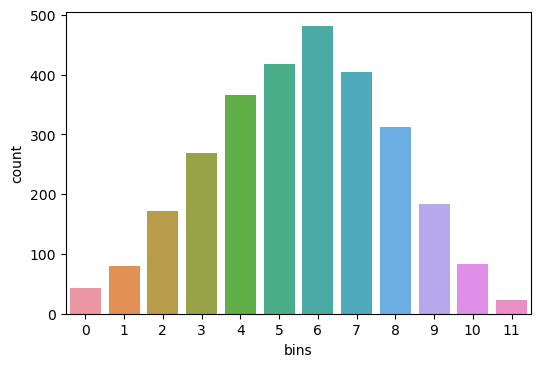

In [8]:
plt.figure(dpi=100)
sns.countplot(train_data.bins);

In [9]:
class CLRPDataset(Dataset):
    def __init__(self,df,tokenizer,max_len=128):
        self.excerpt = df['excerpt'].to_numpy()
        self.targets = df['target'].to_numpy()
        self.max_len = max_len
        self.tokenizer = tokenizer
    
    def __getitem__(self,idx):
        encode = self.tokenizer(self.excerpt[idx],
                                return_tensors='pt',
                                max_length=self.max_len,
                                padding='max_length',
                                truncation=True)
        
        target = torch.tensor(self.targets[idx],dtype=torch.float) 
        return encode, target
    
    def __len__(self):
        return len(self.excerpt)

In [10]:
class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim, num_targets):
        super().__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim
        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim
        
        self.init_weights(self.W, self.V)
    
    def init_weights(self, *blocks):
        for m in blocks:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, features):
        att = torch.tanh(self.W(features))
        score = self.V(att)
        attention_weights = torch.softmax(score, dim=1)
        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector

In [11]:
class Model(nn.Module):
    def __init__(self,path):
        super(Model,self).__init__()
        self.roberta = AutoModel.from_pretrained(path)  
        self.head = AttentionHead(768,768,1)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(768,1)
        
        self.init_weights(self.linear)
    
    def init_weights(self, *blocks):
        for m in blocks:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)
    
    def forward(self,**xb):
        x = self.roberta(**xb)[0]
        x = self.head(x)
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [12]:
class AttentionHead(nn.Module):
    def __init__(self, in_features, hidden_dim):
        super(AttentionHead, self).__init__()
        self.in_features = in_features
        self.middle_features = hidden_dim

        self.W = nn.Linear(in_features, hidden_dim)
        self.V = nn.Linear(hidden_dim, 1)
        self.out_features = hidden_dim

        self.init_weights(self.W, self.V)

    def init_weights(self, *blocks):
        for m in blocks:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, features):
        att = torch.tanh(self.W(features))

        score = self.V(att)

        attention_weights = torch.softmax(score, dim=1)

        context_vector = attention_weights * features
        context_vector = torch.sum(context_vector, dim=1)

        return context_vector


class Model(nn.Module):
    def __init__(self, path):
        print ('=+=============ASDADW')
        super(Model, self).__init__()
        self.roberta = AutoModel.from_pretrained(path)
        self.head = AttentionHead(768,768)
        self.dropout = nn.Dropout(0.1)
        self.linear = nn.Linear(self.head.out_features, 1)

        self.init_weights(self.linear)

    def init_weights(self, *blocks):
        for m in blocks:
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)

    def forward(self, **xb):
        x = self.roberta(**xb)[0]
        x = self.head(x)
        x = self.dropout(x)
        x = self.linear(x)
        return x

In [13]:
def run(fold,verbose=True):
    
    def loss_fn(outputs,targets):
        outputs = outputs.view(-1)
        targets = targets.view(-1)
        return torch.sqrt(nn.MSELoss()(outputs,targets))
    
    def train_and_evaluate_loop(train_loader,valid_loader,model,loss_fn,optimizer,epoch,fold,best_loss,valid_step=10,lr_scheduler=None):
        train_loss = 0
        for i, (inputs1,targets1) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            inputs1 = {key:val.reshape(val.shape[0],-1).to(device) for key,val in inputs1.items()}
            outputs1 = model(**inputs1)
            loss1 = loss_fn(outputs1,targets1.to(device))
            loss1.backward()
            optimizer.step()
            
            train_loss += loss1.item()
            
            if lr_scheduler:
                lr_scheduler.step()
            
            #evaluating for every valid_step
            if (i % valid_step == 0) or ((i + 1) == len(train_loader)):
                model.eval()
                valid_loss = 0
                with torch.no_grad():
                    for j, (inputs2,targets2) in enumerate(valid_loader):
                        inputs2 = {key:val.reshape(val.shape[0],-1).to(device) for key,val in inputs2.items()}
                        outputs2 = model(**inputs2)
                        loss2 = loss_fn(outputs2,targets2.to(device))
                        valid_loss += loss2.item()
                     
                    valid_loss /= len(valid_loader)
                    if valid_loss <= best_loss:
                        if verbose:
                            print(f"epoch:{epoch} | Train Loss:{train_loss/(i+1)} | Validation loss:{valid_loss}")
                            print(f"{g_}Validation loss Decreased from {best_loss} to {valid_loss}{sr_}")

                        best_loss = valid_loss
                        torch.save(model.state_dict(),f'./model{fold}/model{fold}.bin')
                        tokenizer.save_pretrained(f'./model{fold}')
                        
        return best_loss
    
    accelerator = Accelerator()
    print(f"{accelerator.device} is used")
    
    x_train,x_valid = train_data.query(f"Fold != {fold}"),train_data.query(f"Fold == {fold}")
    
    tokenizer = AutoTokenizer.from_pretrained(config['model_path'])
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Model(config['model_path']).to(device)

    train_ds = CLRPDataset(x_train,tokenizer,config['max_len'])
    train_dl = DataLoader(train_ds,
                        batch_size = config["batch_size"],
                        shuffle=True,
                        num_workers = 4,
                        pin_memory=True,
                        drop_last=False)

    valid_ds = CLRPDataset(x_valid,tokenizer,config['max_len'])
    valid_dl = DataLoader(valid_ds,
                        batch_size = config["batch_size"],
                        shuffle=False,
                        num_workers = 4,
                        pin_memory=True,
                        drop_last=False)

    optimizer = optim.AdamW(model.parameters(),lr=config['lr'],weight_decay=config['wd'])
    lr_scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps=0,num_training_steps= 10 * len(train_dl))
    
#     model,train_dl,valid_dl,optimizer,lr_scheduler = accelerator.prepare(model,train_dl,valid_dl,optimizer,lr_scheduler)

    print(f"Fold: {fold}")
    best_loss = 9999
    for epoch in range(config["epochs"]):
        print(f"Epoch Started:{epoch}")
        best_loss = train_and_evaluate_loop(train_dl,valid_dl,model,loss_fn,
                                            optimizer,epoch,fold,best_loss,
                                            valid_step=config['valid_step'],lr_scheduler=lr_scheduler)

In [14]:
for f in range(config['nfolds']):
    run(f)

cuda is used
=+=============ASDADW


Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.decoder.weight', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Fold: 0
Epoch Started:0
epoch:0 | Train Loss:1.5787690877914429 | Validation loss:1.4378865642680063
Validation loss Decreased from 9999 to 1.4378865642680063
epoch:0 | Train Loss:1.1345120397481052 | Validation loss:1.0403314895100064
Validation loss Decreased from 1.4378865642680063 to 1.0403314895100064
epoch:0 | Train Loss:1.0580081741015117 | Validation loss:0.8814635376135508
Validation loss Decreased from 1.0403314895100064 to 0.8814635376135508
epoch:0 | Train Loss:0.9860995546463998 | Validation loss:0.7247089197238287
Validation loss Decreased from 0.8814635376135508 to 0.7247089197238287
epoch:0 | Train Loss:0.9084515273571014 | Validation loss:0.6629468931092156
Validation loss Decreased from 0.7247089197238287 to 0.6629468931092156
epoch:0 | Train Loss:0.8598755393542495 | Validation loss:0.6455279903279411
Validation loss Decreased from 0.6629468931092156 to 0.6455279903279411
epoch:0 | Train Loss:0.8010737467819536 | Validation loss:0.6065693712896771
Validation loss Dec

KeyboardInterrupt: 